<a href="https://colab.research.google.com/github/kiran2424/Live-Class-Monitoring-System-Face-emotion-Recognition-/blob/main/Captstone_Project_5_Live_Class_Monitoring_System_%5BFace_emotion_Recognition%5D_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**
# **Introduction**

---


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

# **Objective**

---


Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**

---


We have utilized the FER 2013 dataset provided on Kaggle.
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

import os

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,MaxPooling2D,Flatten,Conv2D,BatchNormalization,Activation
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools
import datetime



In [2]:
import cv2
from keras.models import load_model
from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.compat.v1.Session(config=config))

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/Live Class Monitoring System [Face emotion Recognition]/FER 2013 Dataset.zip'

In [4]:
from zipfile import ZipFile
with ZipFile(path , 'r') as zip_file:
  zip_file.extractall()
  print('Done!')

Done!


In [5]:
print (len(zip_file.namelist()))


35887


In [6]:
#first 10 extracted file name and its format
for file in (zip_file.namelist()[:10]):
  print(file)

test/angry/PrivateTest_10131363.jpg
test/angry/PrivateTest_10304478.jpg
test/angry/PrivateTest_1054527.jpg
test/angry/PrivateTest_10590091.jpg
test/angry/PrivateTest_1109992.jpg
test/angry/PrivateTest_11296953.jpg
test/angry/PrivateTest_12000629.jpg
test/angry/PrivateTest_12008383.jpg
test/angry/PrivateTest_12191716.jpg
test/angry/PrivateTest_1221822.jpg


To visualize the data we have to use the above path format. Lets do it...

In [7]:
train_dir = 'train'
test_dir = 'test'


Few images from train dataset are...


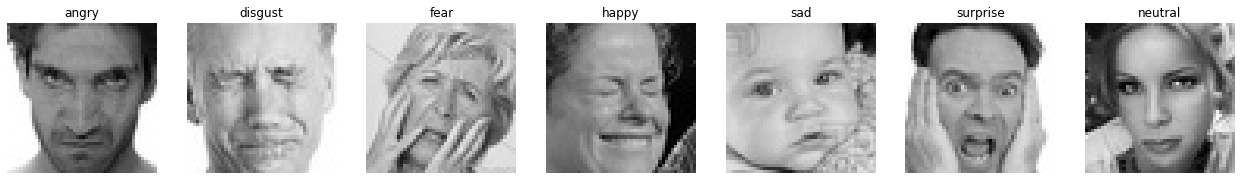

Few images from test dataset are...


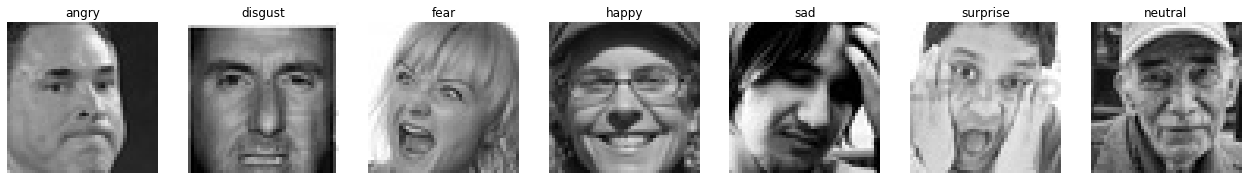

In [8]:
img_size = 48
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print('Few images from train dataset are...')

plt.figure(figsize=(22,24))
i = 1
for expression in emotion_list:
  img_train = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[30]))
  plt.subplot(1,7,i)
  plt.imshow(img_train)
  plt.title(expression)
  plt.axis('off')
  i += 1
plt.show()

print('Few images from test dataset are...')

plt.figure(figsize=(48,48))
j=1
for expression in emotion_list:
  img_test = load_img((test_dir + '/' + expression +'/'+ os.listdir(test_dir + '/' + expression)[30]))
  plt.subplot(1,15,j)
  plt.imshow(img_test)
  plt.title(expression)
  plt.axis('off')
  j += 1
plt.show()



In [9]:
#Normalize pixel value between 0 to 1
train_datagen = ImageDataGenerator(rescale=1./255)
                                   
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_datagen

In [11]:
img_size = 48
batch_size = 64

# Training data.
training_set = train_datagen.flow_from_directory(directory=train_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=True
                                              )

# Validation data.
test_set = test_datagen.flow_from_directory(directory=test_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=False
                                              )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
training_set.class_indices


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [13]:
# First layer
from keras.regularizers import l2

model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1),kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3, 3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer
model.add(Conv2D(128,(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer   
model.add(Conv2D(256,(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth layer
model.add(Conv2D(512,(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# First fully connected layer
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

# Second fully connected layer  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )
print('CNN model has been created successfully')


CNN model has been created successfully


In [14]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

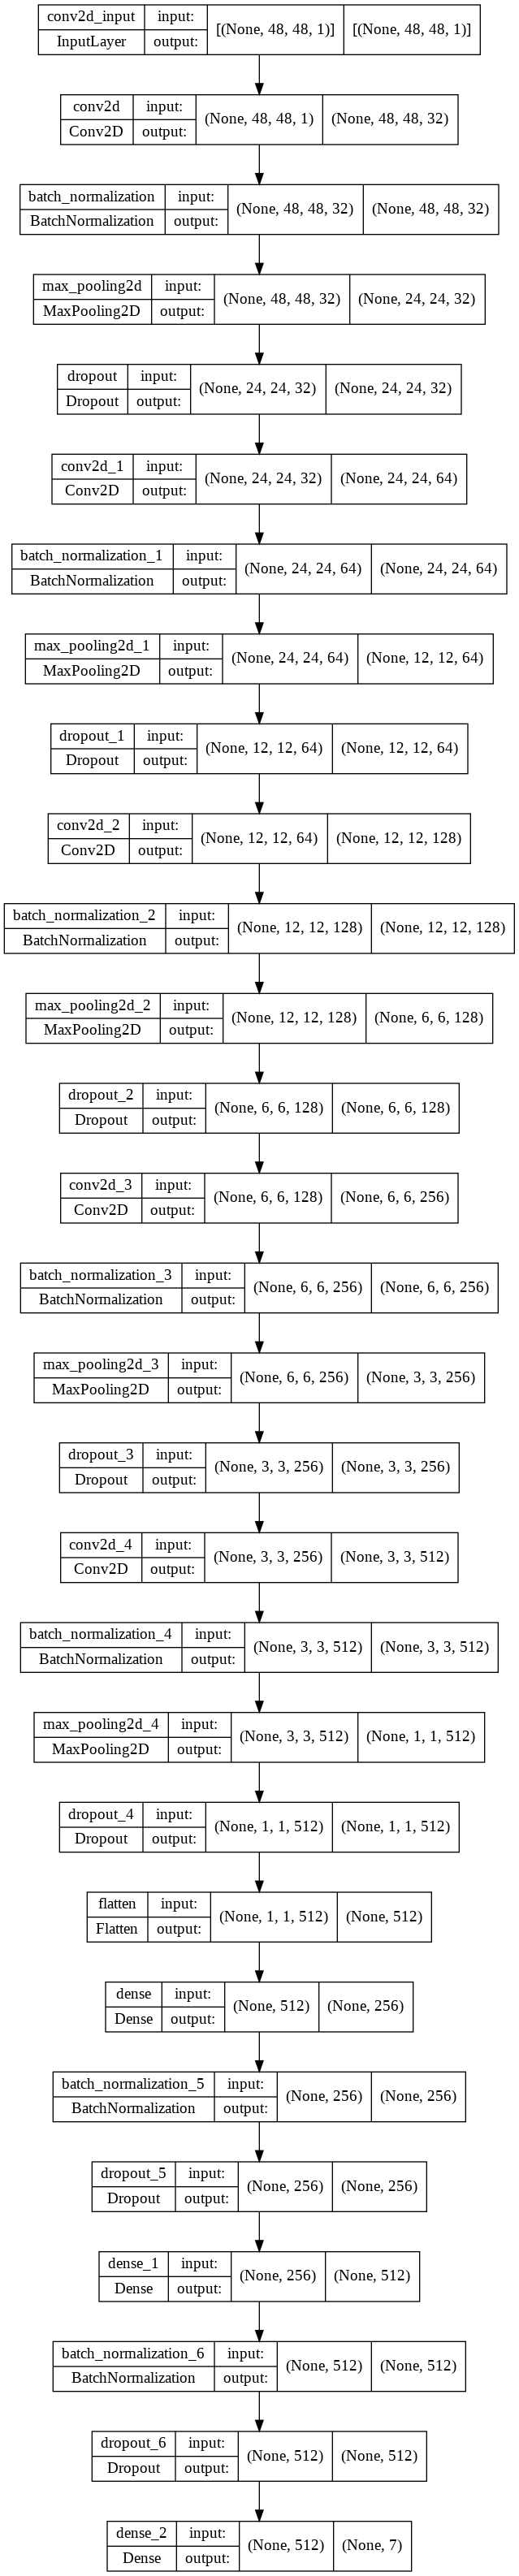

In [15]:
#vizualization of model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [16]:
history = model.fit_generator(generator = training_set,
                              steps_per_epoch=training_set.n//training_set.batch_size,
                              validation_data = test_set,
                              validation_steps=test_set.n//test_set.batch_size,
                              epochs = 25)

print('Your model has been trained!!')



Epoch 1/25
448/448 [==============================] - 361s 802ms/step - loss: 2.1045 - accuracy: 0.2287 - val_loss: 2.0305 - val_accuracy: 0.2518
Epoch 2/25
448/448 [==============================] - 360s 803ms/step - loss: 1.6996 - accuracy: 0.3451 - val_loss: 1.5697 - val_accuracy: 0.3987
Epoch 3/25
448/448 [==============================] - 354s 791ms/step - loss: 1.4964 - accuracy: 0.4303 - val_loss: 1.5683 - val_accuracy: 0.3804
Epoch 4/25
448/448 [==============================] - 355s 792ms/step - loss: 1.3714 - accuracy: 0.4764 - val_loss: 1.3048 - val_accuracy: 0.4962
Epoch 5/25
448/448 [==============================] - 357s 796ms/step - loss: 1.2944 - accuracy: 0.5089 - val_loss: 1.2946 - val_accuracy: 0.5105
Epoch 6/25
448/448 [==============================] - 355s 792ms/step - loss: 1.2444 - accuracy: 0.5341 - val_loss: 1.2310 - val_accuracy: 0.5328
Epoch 7/25
448/448 [==============================] - 356s 794ms/step - loss: 1.1971 - accuracy: 0.5502 - val_loss: 1.1927 -

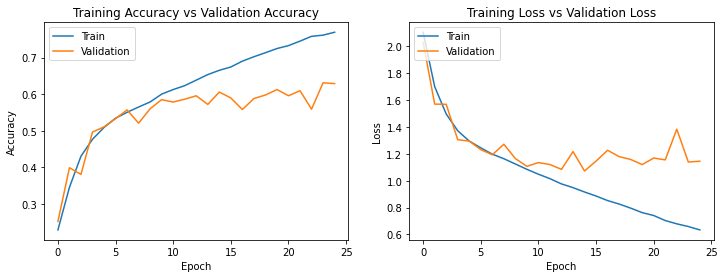

In [17]:
# Create plots for accuracy and loss.
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

<Figure size 432x288 with 0 Axes>

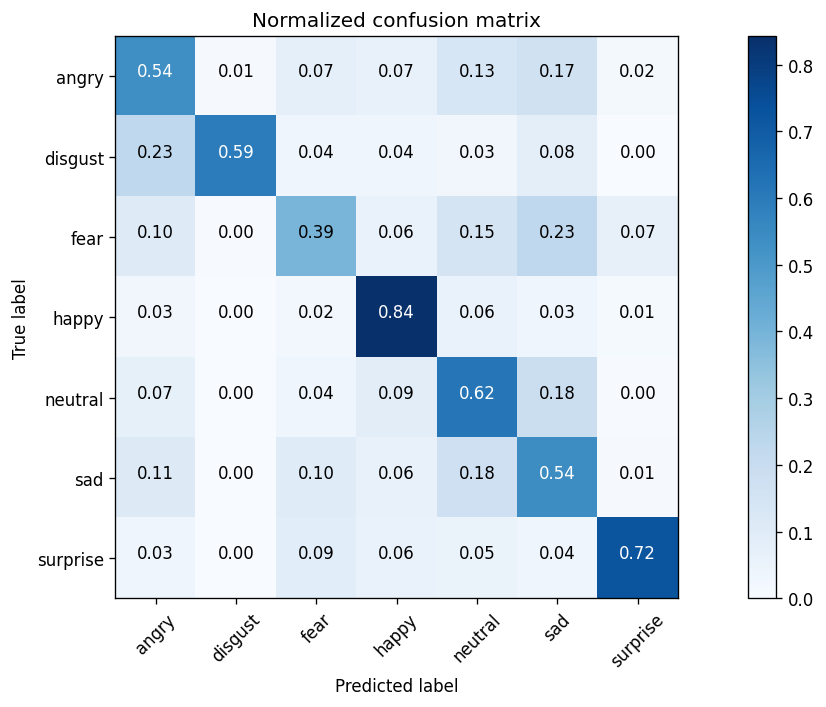

In [19]:
# Create confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

# Create function to plot confussion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

(48, 48)


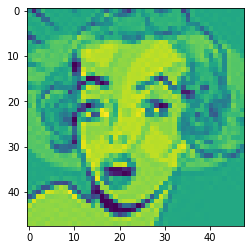

In [68]:
img = image.load_img("/content/train/fear/Training_10230640.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [69]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}


In [70]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [71]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Fear


In [72]:
model.save('model_248.h5')


In [73]:
model.save_weights('model_weights_248.h5')
